In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm

In [2]:
def measure_multiple_light_spots(np_array):
    """
    Measure the diameters of multiple light spots in a NumPy array.
    
    Args:
    np_array (np.ndarray): A 2D or 3D NumPy array containing the image data.
    
    Returns:
    diameters (np.ndarray): Array with the diameters of the detected light spots in pixels.
    positions (np.ndarray): Array with the positions in the image of the detected light spots.
    """
    plt.imshow(np_array)
    plt.show()
    try:
        # Convert the NumPy array to grayscale if it's RGB
        if len(np_array.shape) == 3 and np_array.shape[2] == 3:
            gray = cv2.cvtColor(np_array, cv2.COLOR_BGR2GRAY)
        else:
            gray = np_array
        
        # Apply adaptive thresholding
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        plt.imshow(thresh)
        plt.show()
        # Find contours of all light spots
        contours, _ = cv2.findContours(~thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        plt.imshow(thresh)
        plt.show()
        if len(contours) == 0:
            raise ValueError("No light spots detected in the image.")
        
        # List to store diameters
        diameters = []
        positions = []
        
        # Iterate through all contours
        for contour in contours:
            # Calculate the bounding circle of the contour
            (x, y), radius = cv2.minEnclosingCircle(contour)
            
            # Calculate the diameter
            diameter = 2 * radius
            
            # Append the diameter to the list
            diameters.append(diameter)
            positions.append([x,y])
        
        return np.array(diameters), np.array(positions)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

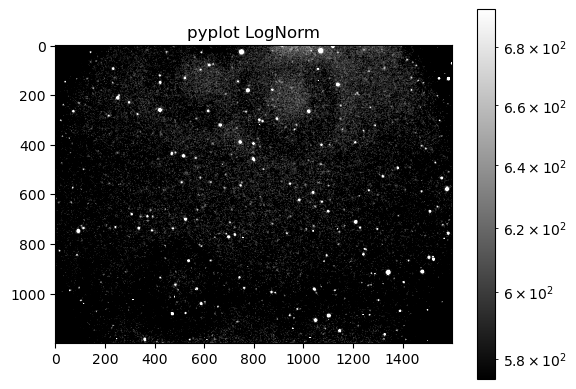

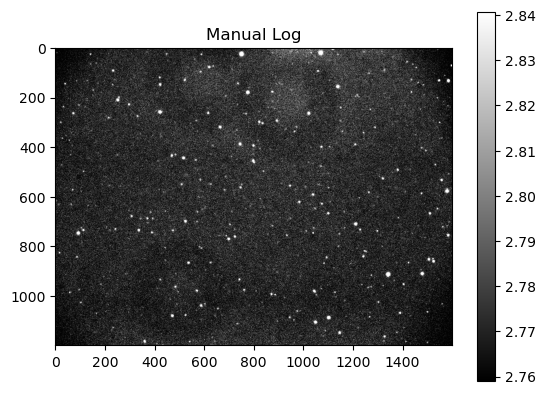

In [3]:
# Open the FITS file
file_path = '111.Altair.fit'
hdul = fits.open(file_path)

# Get the data from the first HDU
image_data = hdul[0].data

# Close the FITS file
hdul.close()

# ============= Plotting the image =============


# Calculate percentiles for more robust limits
vmin, vmax = np.percentile(image_data, (50, 99))

# Plot the image data with logarithmic scale and adjusted contrast
plt.imshow(image_data, cmap='gray', norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.title('pyplot LogNorm')
plt.show()


# ================== Applying log scale to the array itself ==================

# Ensure no negative values for logarithmic transformation
image_data = np.where(image_data > 0, image_data, np.min(image_data))  # Replace 0 or negative values with NaN

# Get indices of pixels that have values less than the range
inds_outs_less = np.where((image_data < vmin))
# Get indices of pixels that have values greater than the range
inds_outs_more = np.where((image_data > vmax))
# Get indices of pixels that have values inside the range
inds_ins = np.where((image_data > vmin) & (image_data < vmax))

# Change the values of the pixels outside the range to the min or max of pixels inside the range
image_data[inds_outs_less] = np.min(image_data[inds_ins])
image_data[inds_outs_more] = np.max(image_data[inds_ins])

# Apply logarithmic scaling
image_data = np.log10(image_data)  # Use natural log (np.log) if preferred

# Normalize to [0,1]
# image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
# image_data = np.log10(image_data)  # Use natural log (np.log) if preferred

# Plot the image data with logarithmic scale and adjusted contrast
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title('Manual Log')
plt.show()


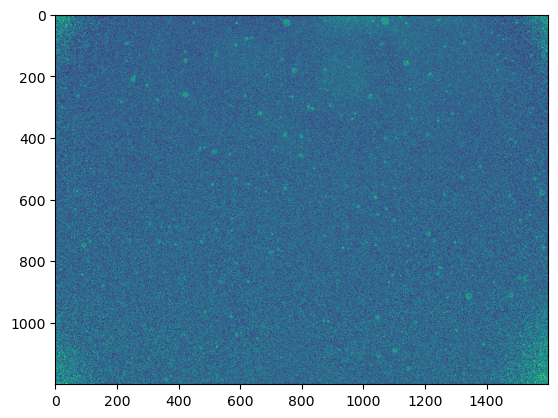

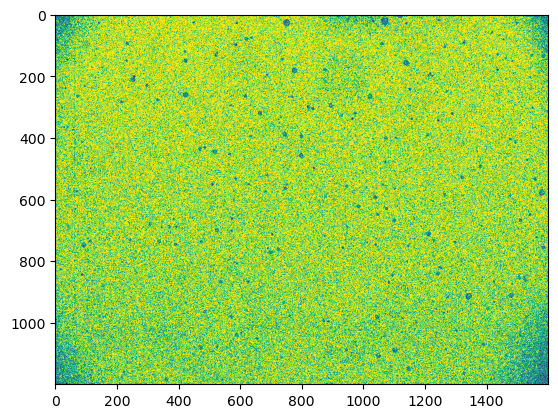

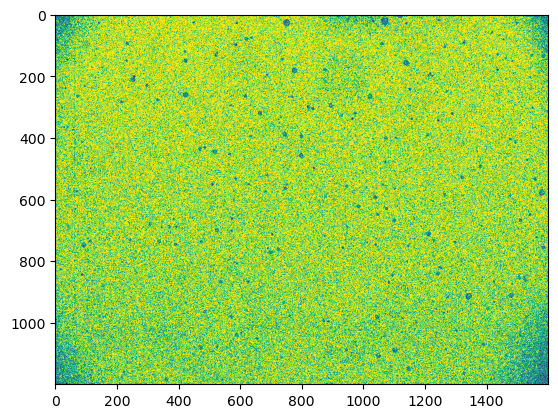

Detected 134577 light spots:


In [4]:
# Open the FITS file
file_path = '111.Altair.fit'
hdul = fits.open(file_path)

# Get the data from the first HDU
image_data_ = hdul[0].data

# Close the FITS file
hdul.close()

# Normaliza la imagen para que los valores estén entre 0 y 255
# img_normalized = cv2.normalize(image_data_, None, 0, 255, cv2.NORM_MINMAX)

# Convierte la imagen normalizada a 8 bits
img_8bit = np.uint8(image_data_)
# img_8bit = np.uint8(img_normalized)

diameters, positions = measure_multiple_light_spots(img_8bit)

if diameters is not None:
    print(f"Detected {len(diameters)} light spots:")
    # for i, diameter in enumerate(diameters, 1):
    #     print(f"Light spot {i}: Diameter ≈ {diameter:.2f} pixels")
else:
    print("Unable to measure the diameters of the light spots.")


Plotting the largest detected spots:

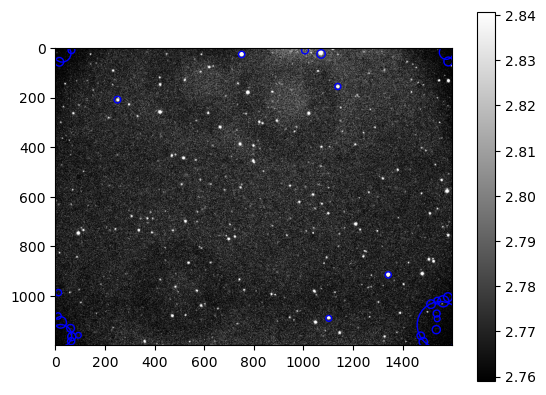

In [5]:
n = 30

# Get the indices of the nth largest detected 'stars'
inds = np.where( np.isin(diameters, np.sort(diameters)[::-1][:n]) )[0]
# Get their radii
rs = diameters[inds]/2
# Get their positions
poss = positions[inds]

fig, ax = plt.subplots()

plt.imshow(image_data, cmap='gray')
# Plot the circles
for s in range(len(rs)):
      circle = plt.Circle((poss[s,0], poss[s,1]), rs[s], color='blue', fill=False)
      ax.add_patch(circle)

plt.colorbar()
plt.show()


Finding density of the spots (to try to get rid of spots that are not stars)

In [6]:
# Get the counts density inside esach of the spots
def get_dens_lum(image, x_center, y_center, radius):
    area = np.pi * radius**2
    values_in_circle = 0
    height, width = image.shape

    for x in range(max(0, x_center - radius), min(width, x_center + radius + 1)):
        for y in range(max(0, y_center - radius), min(height, y_center + radius + 1)):
            if (x - x_center) ** 2 + (y - y_center) ** 2 <= radius ** 2:
                values_in_circle += int(image[y, x])

    return values_in_circle/area


# Get their radii
rs = diameters/2
# Get their positions
poss = positions

# To store the densities of the spots
denss = np.zeros(len(rs))

for i in range(len(rs)):
    x_center, y_center, radius = int(poss[i,0]), int(poss[i,1]), int(rs[i])
    if radius==0:
        denss[i] = 0
        continue
    dens = get_dens_lum(image_data_, x_center, y_center, radius)
    denss[i] = dens

Histogram of the counts density of the spots

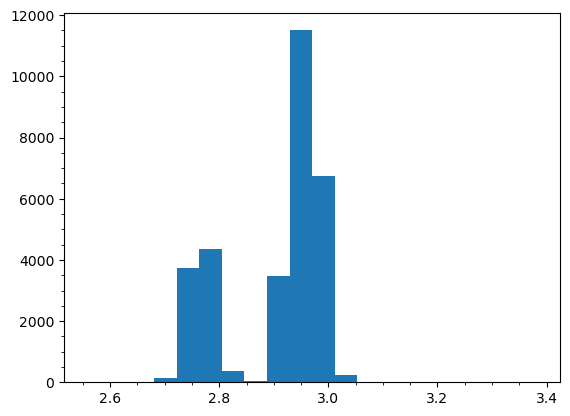

In [7]:
plt.hist(np.log10(denss[np.where(denss!=0)]), bins=20)
plt.minorticks_on()
plt.show()

Plotting the spots in the actual image, with their radii

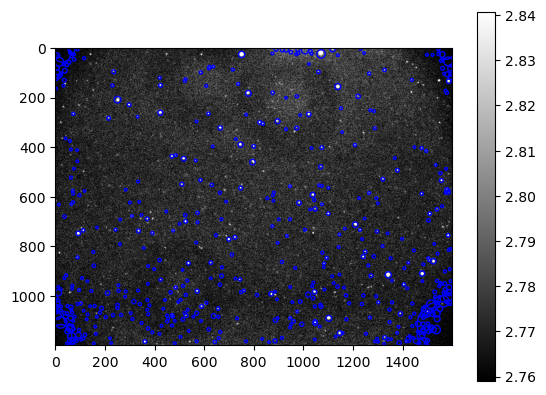

In [8]:
# Get indices for some spots
# Spots with densities greater than some value
inds = np.where( denss > 1 )[0]

# Get their radii
rs = diameters[inds]/2
# Get their positions
poss = positions[inds]

fig, ax = plt.subplots()

plt.imshow(image_data, cmap='gray')
# Plot the circles
for s in range(len(rs)):
      if rs[s] > 5 and rs[s] < 100:
            circle = plt.Circle((poss[s,0], poss[s,1]), rs[s], color='blue', fill=False)
            ax.add_patch(circle)

plt.colorbar()
plt.show()

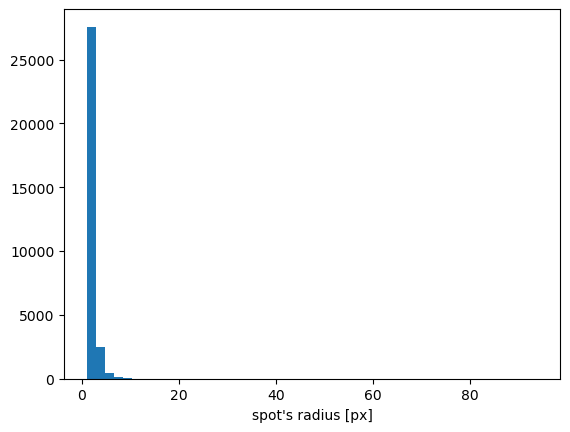

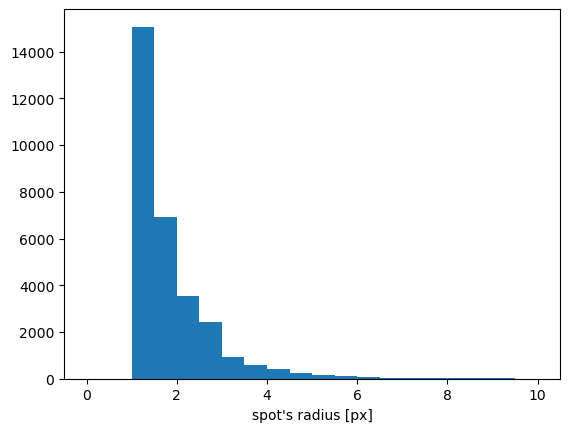

In [9]:
plt.hist(rs, bins=50)
plt.xlabel("spot's radius [px]")
plt.show()

plt.hist(rs, bins=20, range=(0,10))
plt.xlabel("spot's radius [px]")
plt.show()

### Cruce con Catalogo GAIA DR3

Procesando archivo: 111_Altair_v2.fits
INFO: Query finished. [astroquery.utils.tap.core]
....
Se encontraron 10000 objetos en total
....
Aplicando filtro de Magnitudes mas brillantes que 15
....
....
Se encontraron 197 objetos
....


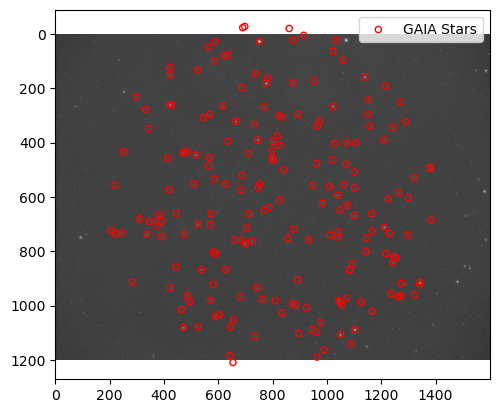

Coordenadas centrales: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (297.88824097, 8.89849159)>


In [11]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia
import os


# Definir el parámetro de escala o tamaño de la placa
scale = 0.822*u.arcsec # ascsec/px pixel scale se obtiene de la astrometria

# Open the FITS file con astrometria
file_path = "111_Altair_v2.fits"
print(f"Procesando archivo: {file_path}")

# Cargar los datos de la imagen FITS
hdul = fits.open(file_path)
image_data = hdul[0].data
header = hdul[0].header
wcs = WCS(header)

# Obtener las coordenadas del centro de la imagen
ny, nx = image_data.shape
center_x = nx / 2
center_y = ny / 2
center_coord = wcs.pixel_to_world(center_x, center_y)

# Definir el tamaño del rectángulo de búsqueda
pixel_width = nx * scale
pixel_height = ny * scale
width = u.Quantity(pixel_width, u.deg)
height = u.Quantity(pixel_height, u.deg)

# Realizar la consulta al catálogo GAIA
Gaia.ROW_LIMIT = 10000
j = Gaia.query_object_async(coordinate=center_coord, width=width, height=height)

# Convertir a pandas para trabajar con los datos de manera más cómoda
results_GAIA = j.to_pandas()
print("....")
print(f"Se encontraron {len (results_GAIA)} objetos en total")
print("....")
print( "Aplicando filtro de Magnitudes mas brillantes que 15")
print("....")

# Aplicar un filtro para la cantidad de objetos obtenidos
filtered_stars = results_GAIA[results_GAIA["phot_g_mean_mag"]<15]
print("....")
print(f"Se encontraron {len (filtered_stars)} objetos")
print("....")

# Obtener las coordenadas de RA y Dec
ra = filtered_stars["ra"]
dec = filtered_stars["dec"]

# Convertir las coordenadas de GAIA a píxeles en la imagen
gaia_coords = SkyCoord(ra=ra.values, dec=dec.values, unit=(u.deg, u.deg))
x, y = wcs.world_to_pixel(gaia_coords)

# Mostrar la imagen FITS con los puntos encontrados

plt.imshow(image_data, cmap="gray", norm=LogNorm(vmin=200, vmax=np.max(image_data)))  # Usar PowerNorm para el escalado logarítmico
plt.scatter(x, y, s=20, edgecolor="red", facecolor="none", label="GAIA Stars")  # Ajustar el tamaño y color de los puntos
plt.legend()
plt.show()
print(f"Coordenadas centrales: {center_coord}")

In [12]:
print(f"ancho: {width}")
print(f"alto: {height}")

ancho: 0.3653333333333333 deg
alto: 0.27399999999999997 deg


In [15]:

from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.utils import calc_total_error
from photutils.centroids import centroid_sources, centroid_com


In [19]:
starloc = list(zip(x,y))

r = 9 # Aperture (px)
r_in = 9 # Sky ring internal radius (px)
r_out = 20 #Sky ring external radius (px)

#Defined them as proper photometric objects using photutils.
circular_aperture = CircularAperture(starloc, r=r)
annulus_aperture = CircularAnnulus(starloc, r_in=r_in, r_out=r_out )
apers = [circular_aperture, annulus_aperture]
phot_table = aperture_photometry(image_data, apers)
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1
,pix,pix,,
int64,float64,float64,float64,float64
1,827.4045385892515,610.8090711094906,149598.46087848532,581775.9165145066
2,786.7198339995997,639.3822418221246,150769.6431550724,580380.5021304416
3,768.7601842054336,650.3015813023773,148381.49885909382,578599.1695281478
4,747.4706648411244,564.2888348083312,158187.5749009042,587050.164851605
5,752.4862094308576,552.8336847089015,151890.46139499475,592211.6399267024
6,712.5624926930352,661.3981656456211,150199.28719273896,579385.6663601038
7,840.2954504449394,499.3634535141447,152880.61539183505,585406.2342273952
8,682.7840202613927,574.4805957591909,153129.93034693954,577320.6916915115


In [21]:
#Area and flux in from the background
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
area_aper = np.array(circular_aperture.area_overlap(image_data))
bkg_sum = bkg_mean * area_aper

#Total flux from each object after substracting background
final_flux = phot_table['aperture_sum_0'] - bkg_sum

In [23]:
# Calculate surface brightness
# surface_brightness = result['aperture_sum'] / (np.pi * apertures.r ** 2)

# Estimate radius based on surface brightness profile
def estimate_radius(sb):
    # This is a simplified model and may need adjustment
    return 2.5 * np.sqrt(1 / sb)

radii = estimate_radius(final_flux)

print(f"Estimated radii: {radii}")

Estimated radii:     aperture_sum_0   
---------------------
 0.057738174788135435
   0.0428727589553008
  0.06532809788317763
  0.02617165449247203
  0.06418759435400567
  0.04502823272098293
  0.03841544367588768
 0.030919552106764146
 0.018018466337553544
  0.03808337642894996
                  ...
  0.04253462720057517
  0.02268169192164392
  0.04599823464950972
                  nan
                  nan
0.0053442201879095215
 0.014877451405039582
                  nan
  0.04524744034268409
                  nan
Length = 197 rows


/tmp/ipykernel_17262/880680823.py:7: RuntimeWarning: invalid value encountered in sqrt
  return 2.5 * np.sqrt(1 / sb)
